# Classification

*The difference between a physicist and an astronomer: The physicist sees random 2D data and draws a curved line in it saying it’s the model that describes the data. The astronomer draws two parallel lines, saying these points belong to class A, these to class B and this is the class C.*

—- Andy Lawrence, private communication

<img src="figures/wumo2.jpg">

In [214]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
%matplotlib inline

In [215]:
import pandas as pd
from astroML.utils import split_samples
from astroML.datasets import fetch_sdss_sspp, fetch_dr7_quasar

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn import preprocessing, metrics

import sklearn.cross_validation as cv
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

#from sklearn.metrics import matthews_corrcoef, make_scorer, average_precision_score

#from scipy.stats import sem
#from scipy import interp

from sklearn.decomposition import PCA #, FastICA
# from wpca import WPCA, EMPCA
# from lpproj import LocalityPreservingProjection
# from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
# from sklearn.learning_curve import learning_curve

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter('ignore')

In [216]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

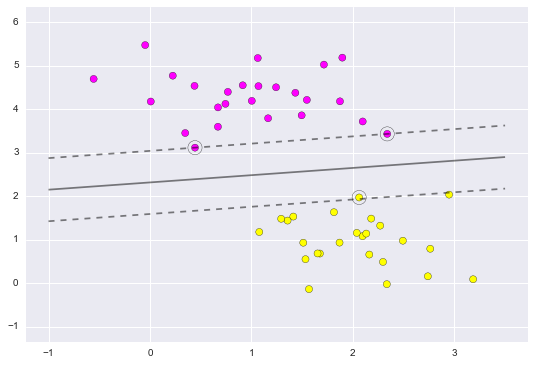

In [217]:
from sklearn.svm import SVC # "Support Vector Classifier"
from sklearn.datasets.samples_generator import make_blobs
Xexample, yexample = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

clf = SVC(kernel='linear')
clf.fit(Xexample, yexample)
plt.figure(figsize=(9,6))
plt.scatter(Xexample[:, 0], Xexample[:, 1], c=yexample, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

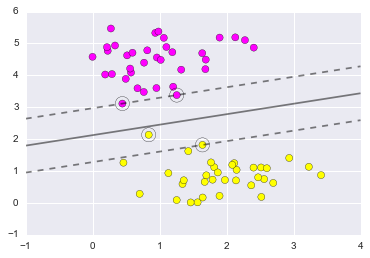

In [218]:
from IPython.html.widgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

# SVM with Non-linear Kernel

In [219]:
from mpl_toolkits import mplot3d
def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

In [241]:
SVC?

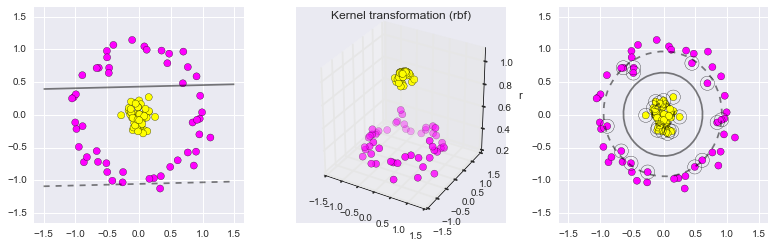

In [220]:
from sklearn.datasets.samples_generator import make_circles
Xexample, yexample = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(Xexample, yexample)

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

ax1 = fig.add_subplot(131)
ax1.scatter(Xexample[:, 0], Xexample[:, 1], c=yexample, s=50, cmap='spring')
plot_svc_decision_function(clf, ax=ax1)


ax2 = fig.add_subplot(132, projection='3d')

### RBF
r = np.exp(-(Xexample[:, 0] ** 2 + Xexample[:, 1] ** 2))
###

ax2.scatter3D(Xexample[:, 0], Xexample[:, 1], r, c=yexample, s=50, cmap='spring')
# ax2 = fig.add_subplot(122, projection='3d')
# ax2.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
# ax2.view_init(elev=30, azim=30)
ax2.set_zlabel('r')
ax2.set_title('Kernel transformation (rbf)')

clf = SVC(kernel='rbf')
clf.fit(Xexample, yexample)

ax3 = fig.add_subplot(133)
ax3.scatter(Xexample[:, 0], Xexample[:, 1], c=yexample, s=50, cmap='spring')
plot_svc_decision_function(clf, ax=ax3)
ax3.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

# Real World Example: Star vs Quasars classification

In [221]:
# load stars
stars = pd.DataFrame()
stars_np = fetch_sdss_sspp()[1::500] # sampling 1::500
stars['mag_u'] = stars_np['upsf']
stars['mag_g'] = stars_np['gpsf']
stars['mag_r'] = stars_np['rpsf']
stars['mag_i'] = stars_np['ipsf']
stars['mag_z'] = stars_np['zpsf']
stars['target'] = 'star'

In [222]:
# load quasars
quasars = pd.DataFrame()
quasars_np = fetch_dr7_quasar()[1::500] # sampling 1::2500
quasars['mag_u'] = quasars_np['mag_u']
quasars['mag_g'] = quasars_np['mag_g']
quasars['mag_r'] = quasars_np['mag_r']
quasars['mag_i'] = quasars_np['mag_i']
quasars['mag_z'] = quasars_np['mag_z']
quasars['target'] = 'QSO'

In [223]:
# get color indices
data = pd.concat([stars,quasars], ignore_index=True)
data['u-g'] = data['mag_u'] - data['mag_g']
data['g-r'] = data['mag_g'] - data['mag_r']
data['r-i'] = data['mag_r'] - data['mag_i']
data['i-z'] = data['mag_i'] - data['mag_z']
Nrows = data.index.size
data.head(3)

,mag_u,mag_g,mag_r,mag_i,mag_z,target,u-g,g-r,r-i,i-z
0,19.240999,17.525999,16.840,16.613001,16.492001,star,1.715,0.685999,0.226999,0.121000
1,19.732000,18.339001,17.767,17.580000,17.481001,star,1.393,0.572001,0.187000,0.098999
2,16.120001,15.232000,14.933,14.845000,14.827000,star,0.888,0.299001,0.087999,0.018001


In [224]:
# data.to_csv('data/sdss_photo.csv', index=False)

In [225]:
# data = pd.read_csv('data/sdss_photo.csv')
# data.head(3)

In [226]:
# Convert to numpy array
dataArray = np.array(data)
# features & targets
X = dataArray[:,6:].astype(float)
labels = dataArray[:,5]
print X.shape, y.shape

(867, 4) (867,)


In [227]:
yFreq = scipy.stats.itemfreq(labels)
print yFreq

[['QSO' 212]
 ['star' 655]]


In [228]:
# scale to have zero mean and unit standard deviation
Xtr = preprocessing.StandardScaler().fit_transform(X)

In [229]:
# perform PCA to enhnace result
pca3 = PCA(n_components=3)
X_pca = pca3.fit_transform(Xtr)

In [230]:
# turn string labels to 0, 1
le = preprocessing.LabelEncoder()
le.fit(labels)
y = le.transform(labels)

In [231]:
# split data to train and test set
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_pca, y,
                                                random_state=2)
print(Xtrain.shape, Xtest.shape)

((650, 3), (217, 3))


In [232]:
# perform the fit and do prediction
# from sklearn.linear_model import LogisticRegression # try tu use LogisticRegression(penalty='l2')
clf = SVC(C=0.1) # try kernel='rbf'
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

## Visualise the Results

In [233]:
print "%f"%(np.sum(ytest == ypred) / float(len(ytest)))

0.990783


In [234]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.99078341013824889

- __Confusion Matrix__
    - False Positives - waste of observational resources on junk
    - False Negatives - missed detections


- __ROC curve__ for a binary classifier
![](figures/roc500.png)

## Metrics

- Accuracy $\equiv \frac{TP + TN}{TP + TN + FP + FN}$ (fraction of good predictions)


- Precision $\equiv \frac{TP}{TP + FP}$ (ability not to label as positive a sample that is negative)


- Recall $\equiv \frac{TP}{TP + FN}$ (ability of the classifier to find all the positive samples)


- f1-score $\equiv 2 \frac{Precision \times Recall }{Precision + Recall}$ (mix)


- Area under ROC (ROC curve in one number)


- Matthew coefficient $\equiv \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP+FN)(TN+FP)(TN+FN)}}$ (balanced mix)

Keep in mind that the metrics is your choice. You can penalize one class etc... Some are simply more used (because of nice math properties) e.g. $\chi^2$ etc.

In [235]:
from sklearn.metrics import confusion_matrix
cm = metrics.confusion_matrix(ytest, ypred)
print(cm)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

[[ 52   1]
 [  1 163]]


In [236]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, column_names=[0,1]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7) # orientation="horizontal", pad=.3
    tick_marks = np.arange(len(column_names))
    plt.xticks(tick_marks, column_names) #, rotation=45)
    plt.yticks(tick_marks, column_names)
    plt.grid(False)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for x in xrange(len(column_names)):
        for y in xrange(len(column_names)):
            plt.annotate('%0.2f'%(cm[y][x]), xy=(x, y), fontsize=26,
                    horizontalalignment='center',
                    verticalalignment='center')

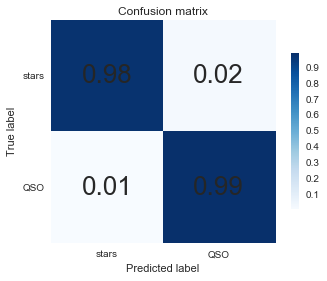

In [237]:
plot_confusion_matrix(cm_norm, column_names=['stars', 'QSO'])

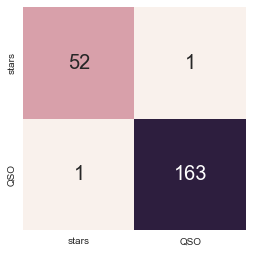

In [238]:
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, annot_kws={'size':20},
            xticklabels=['stars', 'QSO'],
            yticklabels=['stars', 'QSO'])

In [239]:
from sklearn.metrics import classification_report
print classification_report(ypred, ytest)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        53
          1       0.99      0.99      0.99       164

avg / total       0.99      0.99      0.99       217



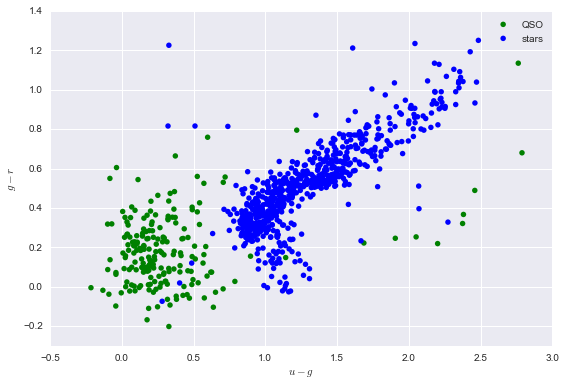

In [240]:
plt.figure(figsize=(9,6))
plt.scatter(X[y==0,0], X[y==0,1], c='g', s=30,
                 linewidths=0, edgecolors='none', label='QSO')
plt.scatter(X[y==1,0], X[y==1,1], c='b', s=30,
                 linewidths=0, edgecolors='none', label='stars')
plt.xlim(-0.5, 3.0)
plt.ylim(-0.3, 1.4)
plt.xlabel('$u - g$')
plt.ylabel('$g - r$')
plt.legend();

## Uneven Classes

Modify the sets to look uneven. The accuracy increases. Why?

check the *weights* keyword

More advanced techniques:

- weights
- sampling & averaging
- generating artificial rare cases